IMPORTING BASIC PYTHON LIBRARIES

***MARKDOWN REPORT***

So in this linear ML model based on Logistic Regression I have tried to create 2 models for fraud detection. The dataset has been taken from kaggle(/content/PS_20174392719_1491204439457_log.csv) and works on the principle of binary classification where the fraud categories are entitled 1 and the non-fraud cases as 0.

A basic workflow of my project is:

1) importing all important modules

2) for simplicity, to deal with missing values I have just removed the rows wirh NaN as they were veru=y few in number.

3) I have , as in all models, split the data in training and validation sets.

4) I have basically built 2 models, one which incorporates Ordinal Encoding approach as a method to deal with categorical variables and the other that incorporates One Hot Encoding. I have later compared the performance to the two models.

5) I tried addressinng class imbalance by incorporating SMOTE, RandomUnderSampling, etc but all it gave me was a worse confusion matrix so ultimately I had to terminate those options.

6) My evaluation metrics include:classification report, matrix and accuracy score. I have also dealt with visual evaluations like AUROC plot and the AUPRC plot along with a shap dependency plot for identifying the most important features.

RESULT: turns out, for this dataset, ordinal encoding model performs slightly better


In [1]:
!pip install -U imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
data= pd.read_csv('/content/PS_20174392719_1491204439457_log.csv')
data.dropna(inplace=True)


DEFINING NECESSARY COLUMNS

In [4]:
all_cols=data.columns
object_cols=[col for col in all_cols if data[col].dtype=='object']
num_cols=[col for col in data.columns if data[col].dtype in ['int64','float64'] and col not in ['isFraud','isFlaggedFraud']]
num_cols_data=[col for col in data.columns if data[col].dtype in ['int64','float64']]

DEFINING SCORE FUNCTION TO FIND THE SCORE OF OUR MODEL BASED ON MEAN ABSOLUTE ERROR

In [5]:
def score_dataset(x_train,x_valid,y_train,y_valid):
  model=LogisticRegression(solver='liblinear',random_state=0,max_iter=1000)
  model.fit(x_train,y_train)
  preds=model.predict(x_valid)
  return mean_absolute_error(y_valid,preds)

SPLITTING DATA FOR TRAINING AND VALIDATION PURPOSES

In [6]:
y=data.isFraud
x=data.drop(['isFraud','isFlaggedFraud'], axis=1)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,random_state=0)
good_label_cols=[col for col in object_cols if set(x_valid[col]).issubset(set(x_train[col]))]
bad_label_cols=list(set(object_cols)-set(good_label_cols))
low_cardinality_cols=[col for col in object_cols if x_train[col].nunique()<10]
high_cardinality_cols=list(set(object_cols)-set(low_cardinality_cols))

In [7]:
print(y.value_counts())

isFraud
0.0    2006071
1.0       2036
Name: count, dtype: int64


ORDINAL ENCODING FOR DEALING WITH CATEGORICAL VARIABLES

In [8]:
label_x_train=x_train.drop(bad_label_cols, axis=1).copy()
label_x_valid=x_valid.drop(bad_label_cols, axis=1).copy()
ordinal_encoder=OrdinalEncoder()
label_x_train[good_label_cols]=ordinal_encoder.fit_transform(x_train[good_label_cols])
label_x_valid[good_label_cols]=ordinal_encoder.transform(x_valid[good_label_cols])
# print(label_x_train.loc[:,num_cols])
scaler=StandardScaler()
label_x_train[num_cols]=scaler.fit_transform(x_train[num_cols])
label_x_valid[num_cols]=scaler.transform(x_valid[num_cols])
# print(label_x_train.loc[:,num_cols])
print('MEAN ABSOLUTE ERROR FROM ORDINAL ENC0DING:')
print(score_dataset(label_x_train,label_x_valid,y_train,y_valid))

MEAN ABSOLUTE ERROR FROM ORDINAL ENC0DING:
0.0007111171311503167


ONE HOT ENCODING FOR DEALING WITH CATEGORICAL VARIABLES

In [9]:
OH_encoder=OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train=pd.DataFrame(OH_encoder.fit_transform(x_train[low_cardinality_cols]))
OH_cols_valid=pd.DataFrame(OH_encoder.transform(x_valid[low_cardinality_cols]))

OH_cols_train.index=x_train.index
OH_cols_valid.index=x_valid.index

num_x_train=x_train.drop(object_cols, axis=1)
num_x_valid=x_valid.drop(object_cols, axis=1)

OH_x_train=pd.concat([num_x_train,OH_cols_train], axis=1)
OH_x_valid=pd.concat([num_x_valid,OH_cols_valid], axis=1)

OH_x_train.columns=OH_x_train.columns.astype(str)
OH_x_valid.columns=OH_x_valid.columns.astype(str)

print('MEAN ABSOLUTE ERROR FROM ONE HOT ENCODING')
print(score_dataset(OH_x_train,OH_x_valid,y_train,y_valid))

MEAN ABSOLUTE ERROR FROM ONE HOT ENCODING
0.0008684791853824595




```
# This is formatted as code
```

FITTING THE MODELS WITH TRAINING DATA

In [10]:
model_ordinal=LogisticRegression(solver='liblinear',random_state=0, max_iter=1000)
model_ordinal.fit(label_x_train, y_train)
preds_ordinal=model_ordinal.predict(label_x_valid)

model_OH=LogisticRegression(solver='liblinear',random_state=0, max_iter=1000)
model_OH.fit(OH_x_train,y_train)
preds_OH=model_OH.predict(OH_x_valid)

EVALUATION OF MODEL (ordinal encoding)

confusion matrix for ordinal encoding model:
 [[501508     14]
 [   343    162]]
accuracy of ordinal encoding model:
 0.9992888828688496
classification report of ordinal encoding model:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    501522
         1.0       0.92      0.32      0.48       505

    accuracy                           1.00    502027
   macro avg       0.96      0.66      0.74    502027
weighted avg       1.00      1.00      1.00    502027



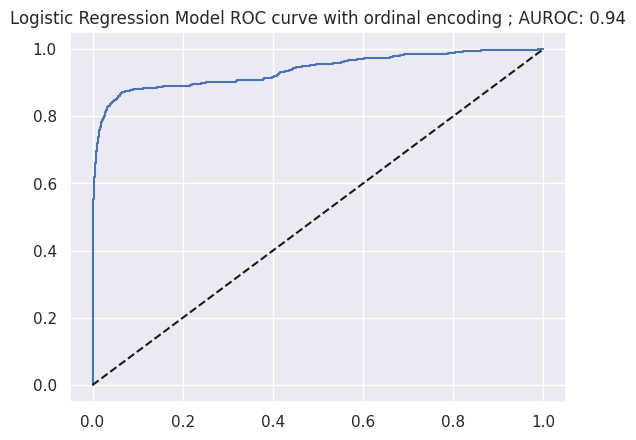

In [11]:
print('confusion matrix for ordinal encoding model:\n',confusion_matrix(y_valid,preds_ordinal))
print('accuracy of ordinal encoding model:\n', accuracy_score(y_valid,preds_ordinal))
print('classification report of ordinal encoding model:\n' , classification_report(y_valid,preds_ordinal))

#AUROC PLOT
y_pred_proba1=model_ordinal.predict_proba(label_x_valid)[::,1]
fpr,tpr,thresholds=roc_curve(y_valid,y_pred_proba1)
auc=roc_auc_score(y_valid,y_pred_proba1)
sns.set()
plt.plot(fpr,tpr)
plt.plot(fpr,fpr,linestyle='--',color='k')
plt.xlabel='False Positive Rate'
plt.ylabel='True Positive Rate'
AUROC=np.round(roc_auc_score(y_valid,y_pred_proba1),2)
plt.title(f'Logistic Regression Model ROC curve with ordinal encoding ; AUROC: {AUROC}');
plt.show()



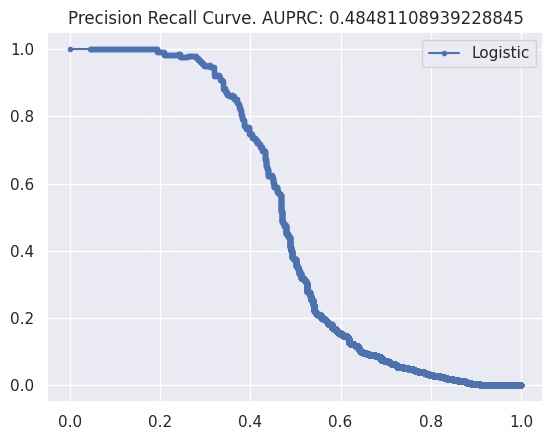

In [12]:
average_precision = average_precision_score(y_valid, y_pred_proba1)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba1)
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel='Recall'
plt.ylabel='Precision'
plt.legend()
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()

EVALUATION OF MODEL (ONE HOT ENCODING)

In [13]:
print('confusion matrix for OH model:\n',confusion_matrix(y_valid,preds_OH))
print('accuracy of OH model:\n', accuracy_score(y_valid,preds_OH))
print('classification report of OH model\n' , classification_report(y_valid,preds_OH))


confusion matrix for OH model:
 [[501369    153]
 [   283    222]]
accuracy of OH model:
 0.9991315208146175
classification report of OH model
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    501522
         1.0       0.59      0.44      0.50       505

    accuracy                           1.00    502027
   macro avg       0.80      0.72      0.75    502027
weighted avg       1.00      1.00      1.00    502027



INCORPORATING SHAP

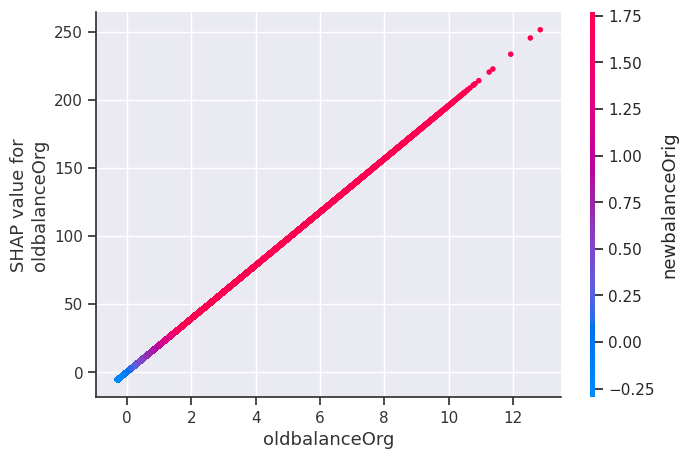

TypeError: 'str' object is not callable

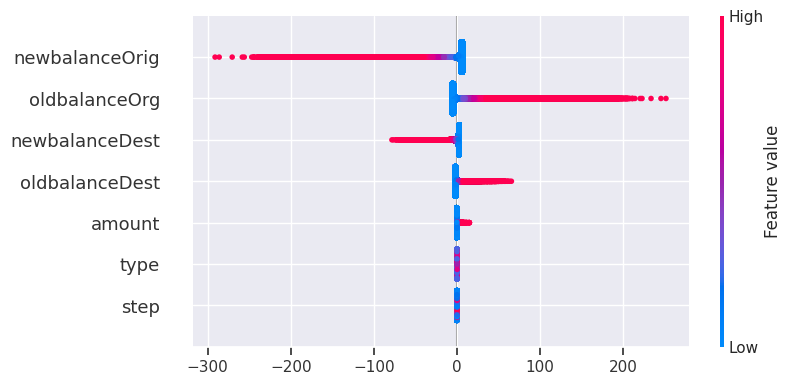

In [14]:
import shap
# Calculate SHAP values
shap_values = shap.LinearExplainer(model_ordinal, label_x_train).shap_values(label_x_valid)
# Create summary plot

shap.dependence_plot('oldbalanceOrg', shap_values, label_x_valid)
shap.summary_plot(shap_values, label_x_valid)